In [546]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

import networkx as nx #Para criar grafo

In [547]:
#------------------------------------ CONSTANTES GLOBAIS ---------------------------------------

ROBOT = '/robotino'

WHEEL1 = '/wheel0_joint'
WHEEL2 = '/wheel1_joint'
WHEEL3 = '/wheel2_joint'

# Robotino
L = 0.135   # Metros
r = 0.040   # Metros

#Limiar
THRESHOLD = 0.5
# Tamanho da célula do nosso Grid (em metros)
CELL_SIZE = 1
#gANHO da minha velocidade
GAIN_SPEED = 5

**1- Fazendo a leitura e planejamento do ambiente**

**Fazendo a leitura do cenário**

In [548]:
def plot_scenery_figure(scenery):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Invertendo os valores para visualização (Branco - 0, Preto - 1)
    img = 1 - mpimg.imread(scenery)

    # Apenas para garantir que só teremos esses dois valores
    img[img > THRESHOLD] = 1
    img[img<= THRESHOLD] = 0

    ax.imshow(img, cmap='Greys', origin='upper')
    return img

**Plotando o grid do cenário**

In [549]:
def plot_grid_by_img_scenery(img_scenery,map_dims):

    # Escala Pixel/Metro
    sy = img_scenery.shape[0] / map_dims[0]
    sx = img_scenery.shape[1] / map_dims[0]

    # print("Escala Pixel/Metro = ", sy, sx)

    rows, cols = (map_dims / CELL_SIZE).astype(int)  #40x40/1 -> vou ter 40x40 grids
    grid = np.zeros((rows, cols)) #criando a matriz com o tamanho do meu ambiente de acordo tamanho da minha célula

    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):
            
            xi = int(c*CELL_SIZE*sx)
            xf = int(xi + CELL_SIZE*sx)
            # print("xi, xf = ", xi,xf)
            
            yi = int(r*CELL_SIZE*sy)
            yf = int(yi + CELL_SIZE*sy)
            # print("yi, yf = ", yi,yf)
                        
            grid[r, c] = np.sum(img_scenery[yi:yf,xi:xf]) #somo pixels dentro do grid
            
    # Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
    grid[grid > THRESHOLD] = 1
    grid[grid<= THRESHOLD] = 0        

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando Mapa e Células
    obj = ax.imshow(img_scenery, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, CELL_SIZE))
    ax.set_yticks(np.arange(0, map_dims[0]+1, CELL_SIZE))

    return rows, cols, grid

**Plotando o grafo para o Grid**

In [550]:
def plot_graph_by_grid(rows, cols, grid, map_dims):
    
    # Criando vértices em todas as células
    G = nx.grid_2d_graph(rows, cols) 

    # Removendo os vértices das células que estão em células marcas com obstáculos
    for row in range(rows):
        for col in range(cols):
            if grid[row][col] == 1:  
                G.remove_node((row,col))


    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Grid
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, CELL_SIZE))
    ax.set_yticks(np.arange(0, map_dims[0]+1, CELL_SIZE))

    # Os vértices serão plotados no centro da célula  
    pos = {node:(node[1]*CELL_SIZE+CELL_SIZE/2, map_dims[0]-node[0]*CELL_SIZE-CELL_SIZE/2) for node in G.nodes()}
    print(pos)
    nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

    return G, pos

**Achando o menor caminho**

In [551]:
def plot_shortest_path(qstart, qgoal, grid, map_dims, G, pos):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Mapa
    obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

    # Caminho
    # qstart = (18,9)
    # qgoal = (1,18)  
    path = nx.shortest_path(G, source=qstart, target=qgoal)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

    # qgoal = (13,10)
    # path = nx.shortest_path(G, source=qstart, target=qgoal)
    # nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='r')

    # qgoal = (1,1)
    # path = nx.shortest_path(G, source=qstart, target=qgoal)
    # nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='y')

    return path

**2 - Controle**

In [552]:
#faz conexão com a cena
try:
    client = RemoteAPIClient()
    sim = client.require('sim')
except:
    print('Error connection')

In [553]:
def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

In [554]:
def navigation(qgoal, Mdir, gain, wheels):

    objectHandle_Robot = sim.getObject(ROBOT)

    while True:
        pos = sim.getObjectPosition(objectHandle_Robot)
        ori = sim.getObjectOrientation(objectHandle_Robot)

        q_robot = np.array([pos[0], pos[1], ori[2]])

        error_vector = qgoal - q_robot
        error_norm = np.linalg.norm(error_vector[:2]) 

        if (error_norm < 0.05):
            break

        # if (error_vector[0]==0 or error_vector[0]==0):
        #     break

        # Controller
        qdot = gain @ error_vector #[velocidades] - É o erro vezes minha matriz de ganho

        #w1,w2,w3
        Minv = np.linalg.inv(Rz(q_robot[2]) @ Mdir)
        u = Minv @ qdot

        #Enviando Velocidades
        sim.setJointTargetVelocity(wheels[0], GAIN_SPEED * u[0])
        sim.setJointTargetVelocity(wheels[1], GAIN_SPEED * u[1])
        sim.setJointTargetVelocity(wheels[2], GAIN_SPEED * u[2])

    


**RESULTADOS CENÁRIO 1**

In [555]:
#------------------------------------ CONSTANTES PARA O CENÁRIO 1 ---------------------------------------
SCENERY_PAREDES = 'img_maps/paredes_map_invertido.png'
# Dimensões do mapa informado em metros (X, Y)
MAP_DIMS_PAREDES = np.array([20, 20]) 

In [556]:
#------------------------------------Definindo meu qstart e meu qgoal - CENÁRIOS DE TESTES --------------------------------------

#------------------------------------ Testes para a documentação --------------------------------------
#------------------------------------Teste 1--------------------------------------

# qstart = (16,2) 
# qgoal = (1,18)  

#------------------------------------Teste 2--------------------------------------
# qstart = (10, 18) 
# qgoal = (13,10)

#------------------------------------Teste 3--------------------------------------
# qstart = (18, 18) 
# qgoal = (1,1)

#------------------------------------ Testes Para o monitor --------------------------------------

qstart = (18,9)
qgoal = (1,18) 
# qgoal = (13,10)
# qgoal = (1,1) 



In [557]:
# #----------------Calculando a rota: ROADMAP GRID E NAVEGAÇÃO---------------------------
img = plot_scenery_figure(SCENERY_PAREDES)
rows, cols, grid= plot_grid_by_img_scenery(img, MAP_DIMS_PAREDES)
G, pos = plot_graph_by_grid(rows, cols, grid, MAP_DIMS_PAREDES)
path = plot_shortest_path(qstart, qgoal, grid, MAP_DIMS_PAREDES, G, pos)

#---------------- INICIANDO NAVEGAÇÃO ---------------------------
sim.startSimulation()

objectHandle_Robot = sim.getObject(ROBOT)

#Vetor para realizar a translação!!
pBorg = [-10, -10, 0]

#Resgatando as rodas
wheel1 = sim.getObject(WHEEL1)
wheel2 = sim.getObject(WHEEL2)
wheel3 = sim.getObject(WHEEL3)
wheels = [wheel1,wheel2,wheel3]

Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]]) 
#Matriz de ganhos
gain = np.array([[0.05, 0, 0], [0, 0.05, 0], [0, 0, 0.05]])

#Fazendo a navegação
for p in path:
    coordinate = pos[p]
    qGraph = np.array([coordinate[0],coordinate[1],0])
    qgoal = qGraph + pBorg
    navigation(qgoal, Mdir, gain, wheels)

#Parando meu robo
sim.setJointTargetVelocity(wheel1, 0)
sim.setJointTargetVelocity(wheel2, 0)
sim.setJointTargetVelocity(wheel3, 0)

sim.stopSimulation()

**RESULTADOS CENÁRIO 2**

In [558]:
#------------------------------------ CONSTANTES PARA O CENÁRIO 2 ---------------------------------------
SCENERY_CAVE = 'img_maps/cave_map_invertido.png'
# Dimensões do mapa informado em metros (X, Y)
MAP_DIMS_CAVE = np.array([40, 40]) 

In [559]:
#------------------------------------Definindo meu qstart e meu qgoal - CENÁRIOS DE TESTES --------------------------------------

# qstart e qgoal com GRID 1 - Posições que Estressam o modelo com esse valor de célula ----------------
# CELL_SIZE = 1 #Estressa o modelo nesse mapa
# qstart = (34,8) 
# qgoal = (4, 36) 
# qgoal = (27,36)

#--------------------------- TESTES PARA O MONITOR ---------------------------
CELL_SIZE = 2 #Não estressa o modelo nesse mapa
#--------------------------- TESTE 1 ------------------------
qstart = (16,5)
qgoal = (13,17)
#-------------------------------- TESTE 2 --------------------
# qgoal = (3,2)

{(4, 4): (4.5, 35.5), (4, 14): (14.5, 35.5), (4, 15): (15.5, 35.5), (4, 16): (16.5, 35.5), (4, 17): (17.5, 35.5), (4, 18): (18.5, 35.5), (4, 19): (19.5, 35.5), (4, 20): (20.5, 35.5), (4, 21): (21.5, 35.5), (4, 22): (22.5, 35.5), (4, 23): (23.5, 35.5), (4, 24): (24.5, 35.5), (4, 25): (25.5, 35.5), (4, 26): (26.5, 35.5), (4, 27): (27.5, 35.5), (4, 28): (28.5, 35.5), (4, 29): (29.5, 35.5), (4, 30): (30.5, 35.5), (4, 31): (31.5, 35.5), (4, 32): (32.5, 35.5), (4, 33): (33.5, 35.5), (4, 34): (34.5, 35.5), (4, 35): (35.5, 35.5), (4, 36): (36.5, 35.5), (5, 4): (4.5, 34.5), (5, 5): (5.5, 34.5), (5, 14): (14.5, 34.5), (5, 15): (15.5, 34.5), (5, 16): (16.5, 34.5), (5, 24): (24.5, 34.5), (5, 25): (25.5, 34.5), (5, 26): (26.5, 34.5), (5, 27): (27.5, 34.5), (5, 28): (28.5, 34.5), (5, 29): (29.5, 34.5), (5, 30): (30.5, 34.5), (5, 31): (31.5, 34.5), (5, 32): (32.5, 34.5), (5, 33): (33.5, 34.5), (5, 34): (34.5, 34.5), (5, 35): (35.5, 34.5), (5, 36): (36.5, 34.5), (6, 4): (4.5, 33.5), (6, 5): (5.5, 33.5

KeyboardInterrupt: 

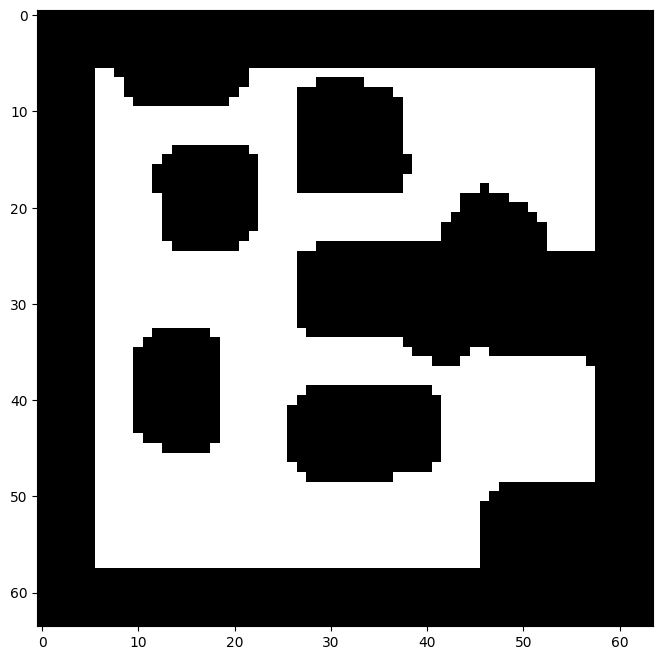

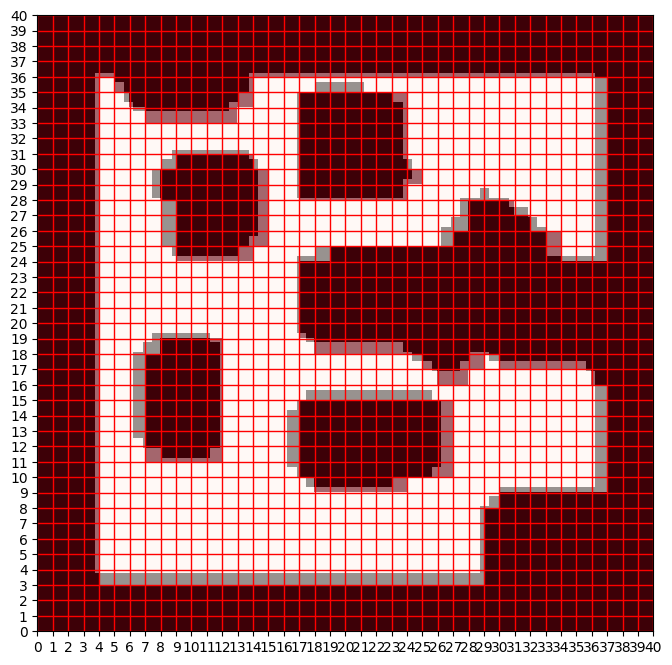

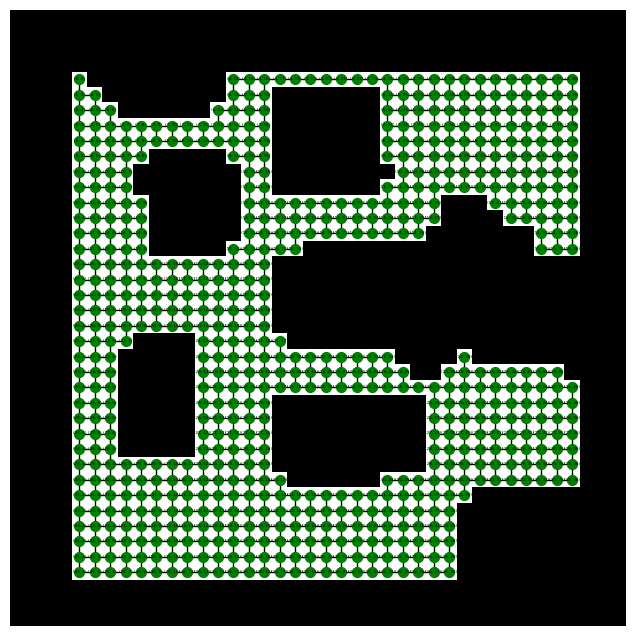

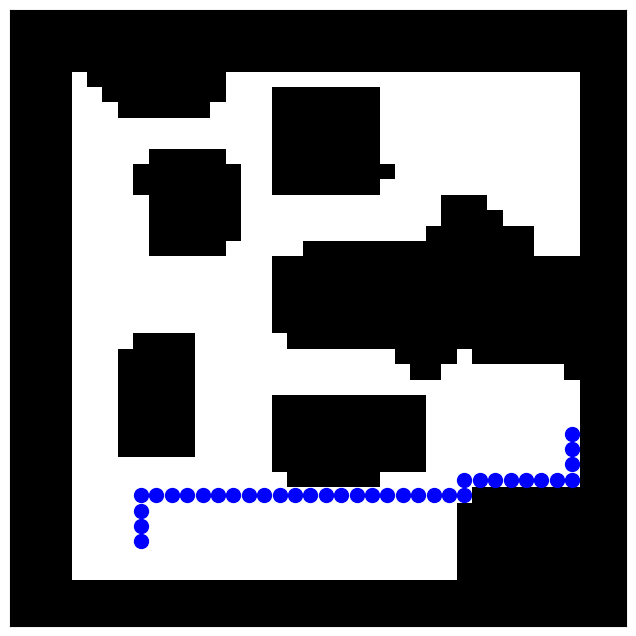

In [560]:
#----------------Calculando a rota: ROADMAP GRID---------------------------
img = plot_scenery_figure(SCENERY_CAVE)
rows, cols, grid= plot_grid_by_img_scenery(img, MAP_DIMS_CAVE)
G, pos = plot_graph_by_grid(rows, cols, grid, MAP_DIMS_CAVE)
path = plot_shortest_path(qstart, qgoal, grid, MAP_DIMS_CAVE, G, pos)

#---------------- INICIANDO NAVEGAÇÃO ---------------------------
sim.startSimulation()

objectHandle_Robot = sim.getObject(ROBOT)

#Vetor para realizar a translação!!
pBorg = [-20, -20, 0]

#Minhas rodas
wheel1 = sim.getObject(WHEEL1)
wheel2 = sim.getObject(WHEEL2)
wheel3 = sim.getObject(WHEEL3)
wheels = [wheel1,wheel2,wheel3]

Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]]) 
#Matriz de ganhos
gain = np.array([[0.05, 0, 0], [0, 0.05, 0], [0, 0, 0.05]])

#Fazendo a navegação
for p in path:
    coordinate = pos[p]
    qGraph = np.array([coordinate[0],coordinate[1],0])
    qgoal = qGraph + pBorg
    navigation(qgoal, Mdir, gain, wheels)

# # #Parando meu robo
sim.setJointTargetVelocity(wheel1, 0)
sim.setJointTargetVelocity(wheel2, 0)
sim.setJointTargetVelocity(wheel3, 0)

sim.stopSimulation()
